In [1]:
# compute covariance
def cov(x1,x2):
  return np.mean((x1 - np.mean(x1)) * (x2 - np.mean(x2)))

# compute image similarity
def get_similarity(img1, img2, SIM_INDEX):
  if(SIM_INDEX == 'SSD'):
    # sum of squared differences
    score = np.sum(np.square(img1 - img2))
  elif(SIM_INDEX == 'NCC'):
    # normalised cross-correlation
    score = np.sqrt(abs(cov(img1,img2) / (cov(img1,img1) * cov(img2,img2))))
  elif(SIM_INDEX == 'SSIM'):
    # structural similarity index, note: L = 1
    c1 = 0.01
    c2 = 0.03
    p1 = ((img1 - np.mean(img1)) * (img2 - np.mean(img2)) + c1) / (
      np.square(img1 - np.mean(img1)) + np.square(img2 - np.mean(img2)) + c1)
    p2 = 2 * (np.sqrt(abs(cov(img1,img2))) + c2) / (cov(img1,img1) + cov(img2,img2) + c2)
    score = np.mean(p1 * p2)
    
  return score


In [2]:
# align the channels
def align_image_channels_pyramids(img, row_idx, col_idx, DELTA, SIM_INDEX = 'SSD'):
  ch_ref = img[0,:,:] # reference channel
  rshift = np.zeros(2,dtype=np.int32) # shifts for optimal alignment
  cshift = np.zeros(2,dtype=np.int32)
  
  for ch in range(1,3):
    if(SIM_INDEX == 'SSD'):
      best_sim_score = float('inf')
      ineq_expr = 'sim_score < best_sim_score'
    else:
      best_sim_score = float('-inf')
      ineq_expr = 'sim_score > best_sim_score'
  
    # shift for each plausible row and column
    for u in range(row_idx[ch-1]-DELTA, row_idx[ch-1]+DELTA+1):
      for v in range(col_idx[ch-1]-DELTA, col_idx[ch-1]+DELTA+1):
        # best alignment for channels
        ch_dis = np.roll(img[ch,:,:], (u,v), axis=(0,1))
        sim_score = get_similarity(ch_ref, ch_dis, SIM_INDEX)
        if(eval(ineq_expr)):
          best_sim_score = sim_score
          rshift[ch-1] = u
          cshift[ch-1] = v
  
  return [rshift, cshift]


In [3]:
# form image pyramids
def pyramid_reduce(img):
  fil_img = np.transpose(img, (1,2,0))
  fil_img = cv2.resize(fil_img, None, fx=0.5, fy=0.5) # decimate by factor of 2
  
  return np.transpose(fil_img, (2,0,1))

def image_colorization(img, level, MAX_PYMD_LEVEL, SIM_INDEX):  
  # recursively downsample image till pyramid level MAX_PYMD_LEVEL
  if(level < MAX_PYMD_LEVEL):
    [rshift, cshift] = image_colorization(pyramid_reduce(img), level+1, MAX_PYMD_LEVEL, SIM_INDEX)
  else:
    rshift = np.zeros(2,dtype=np.int32)
    cshift = np.zeros(2,dtype=np.int32)
  
  start_time = time.time()
  # estimate alignment parameters
  if(level ==  MAX_PYMD_LEVEL):
    rshift, cshift = align_image_channels_pyramids(img, rshift, cshift, 20, SIM_INDEX) # coarse, search larger region
  else:
    rshift, cshift = align_image_channels_pyramids(img, 2*rshift, 2*cshift, 2, SIM_INDEX) # precision search
  print(rshift,cshift)
  print("Computation time at level %d: %d secs" % (level, time.time() - start_time))

  return [rshift, cshift]


In [4]:
def preprocess_image(DATA_ROOT, SIM_INDEX, MAX_PYMD_LEVEL, EDGE_DET, crop=(0,0)):
  C = 3 # no. of channels

  # slice image into RGB channels and generate crops to 
  # deal with black border artifacts
  glass_plate_image = cv2.imread(DATA_ROOT,0)
  glass_plate_image = cv2.normalize(glass_plate_image.astype('float'), 
                                    None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  
  H,W = glass_plate_image.shape
  H = (H - (H % 3)) // C # make image height a multiple of 3
  fig = mp_plt.figure(figsize=(16,16))
  true_img = np.empty((C, H, W))
  img = np.empty((C, H - 2*crop[0], W - 2*crop[1]))
  for i in range(C):
    true_img[i,:,:] = glass_plate_image[i*H:(i+1)*H,:]
    img[i,:,:] = glass_plate_image[i*H+crop[0]:(i+1)*H-crop[0],crop[1]:W-crop[1]]
    fig.add_subplot(1,3,i+1)
    imgplot = mp_plt.imshow(true_img[i,:,:])
    imgplot.set_cmap('gist_gray')
      
  # get colorized image
  if(EDGE_DET is True):
    transformed_img = np.empty_like(img)
    transformed_img[0,:,:] = feature.canny(img[0,:,:])
    transformed_img[1,:,:] = feature.canny(img[1,:,:])
    transformed_img[2,:,:] = feature.canny(img[2,:,:])
  else:
    transformed_img = img
    
  return [transformed_img, true_img]


In [5]:
def main_routine(MAX_PYMD_LEVEL, SIM_INDEX, CROP, EDGE_DET, IMAGE_NAME, DATA_ROOT):
  start_time = time.time()
  s1 = time.time()
  img, true_img = preprocess_image(DATA_ROOT+IMAGE_NAME, SIM_INDEX, MAX_PYMD_LEVEL, EDGE_DET, (CROP,CROP))
  print("Time required for preprocessing: %d secs" % (time.time() - start_time))

  # colorize image
  [rshift, cshift] = image_colorization(img, 0, MAX_PYMD_LEVEL, SIM_INDEX)

  # align image
  colorized_image = np.empty_like(true_img)
  colorized_image[0,:,:] = true_img[0,:,:]
  colorized_image[1,:,:] = np.roll(true_img[1,:,:], (rshift[0],cshift[0]), axis=(0,1))
  colorized_image[2,:,:] = np.roll(true_img[2,:,:], (rshift[1],cshift[1]), axis=(0,1))
  print("Time required for preprocessing: %d secs" % (time.time() - start_time))
  # show the image
  mp_plt.figure(figsize=(16,16))
  view_img = np.transpose(colorized_image, (1,2,0))
  mp_plt.imshow(view_img[:,:,[2,1,0]])
  
  # save the image
  save_img = np.transpose(colorized_image, (1,2,0)) * 255
  save_img = save_img.astype(np.uint8)
  cv2.imwrite(IMAGE_NAME[:-4]+".jpg",save_img,[cv2.IMWRITE_JPEG_QUALITY,50])
      
  return save_img

Running Image Colorisation...
Time required for preprocessing: 1 secs
[ 5 11] [2 2]
Computation time at level 4: 0 secs
[10 22] [4 5]
Computation time at level 3: 0 secs
[20 44] [7 9]
Computation time at level 2: 0 secs
[39 88] [14 18]
Computation time at level 1: 1 secs
[ 78 176] [28 37]
Computation time at level 0: 6 secs
Time required for preprocessing: 11 secs
Total Computation Time: 12 secs


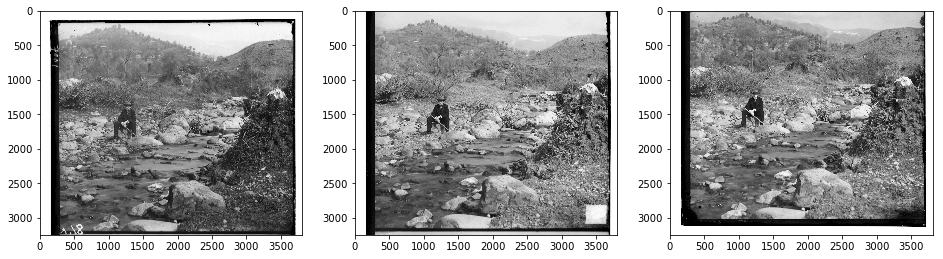

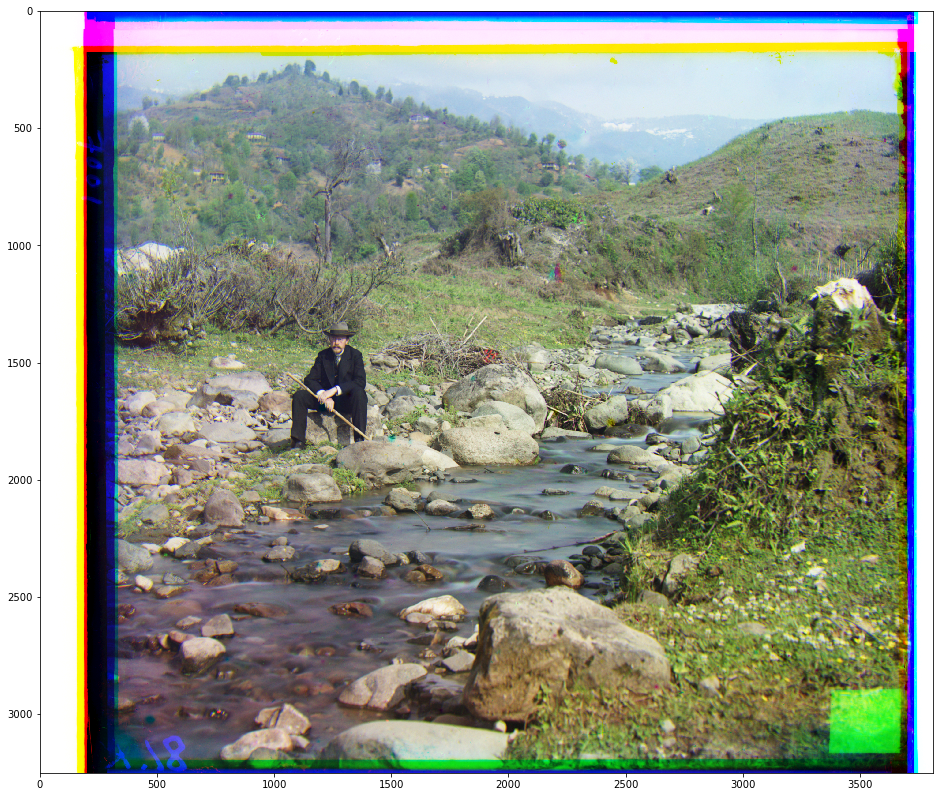

In [6]:
import numpy as np
import cv2
from skimage import feature
import matplotlib.pyplot as mp_plt
import time
%matplotlib inline

print("Running Image Colorisation...")
MAX_PYMD_LEVEL = 4
SIM_INDEX = 'SSD'
CROP = 250
EDGE_DET = False
IMAGE_NAME = 'self_portrait.tif'
DATA_ROOT = 'F:/Projects/CSCE 689 - Computational Photography/'
      
start_time = time.time()
save_img = main_routine(MAX_PYMD_LEVEL, SIM_INDEX, CROP, EDGE_DET, IMAGE_NAME, DATA_ROOT)
print("Total Computation Time: %d secs" % (time.time() - start_time))